In [19]:
import jax.numpy as jnp
from jax import nn
import numpy as np
from matplotlib import pyplot as plt

from descent_methods import *
from utilities import MSELoss_method, jax_loss_grad, feature_matrix, train_test_split

In [20]:
# simple function
def f(x):
    return x + x**2

def FrankeFunction(x,y):
  term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
  term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
  term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
  term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
  return term1 + term2 + term3 + term4# + np.random.normal(scale=0.1,size=x.shape)


def feature_matrix_2d(x, y, num_features):
    """
    Generates a feature matrix based on x, y and the number of features.
    
    The function constructs features by taking combinations of powers of x and y,
    starting with the highest power of x.

    x: A 2D array with a single column of input values.
    y: A 2D array with a single column of input values.
    num_features: The number of feature columns.

    X: The feature matrix,a 2D numpy array with a column for each feature
    """
    X = np.zeros((len(x), num_features))

    deg = 0
    n   = 0
    while True:
        for i in range(0, deg+1):

            # Add feature row
            X[:,n] = x[:, 0]**(deg-i) * y[:, 0]**i

            # Increment number of points done, and end if needed
            n += 1
            if n == num_features:
                
                return X

        deg += 1


def r2_sampling(num_points, sigma2 = 0):
    """
    To add noise, input sigma2 > 0.
    """

    x = np.random.random(( num_points, 1))
    y = np.random.random((num_points, 1))

    z = FrankeFunction(x, y) + np.random.normal(0, np.sqrt(sigma2), size=(num_points, 1))

    return {'x':x, 'y':y, 'z':z}

In [21]:
def sigmoid(x):
    return 1 / (1+jnp.exp(-x))

def relu(x):
    return jnp.maximum(0, x)

def leaky_relu(x, alpha = 0.5):
    return jnp.maximum(0, x) + alpha*jnp.minimum(x, 0)

def leaky_relu_stochastic(x, alpha_min=0, alpha_max=1):
    alpha = np.random.uniform(alpha_min, alpha_max)
    return leaky_relu(x, alpha=alpha)

In [22]:

num_points = 100

layers = [6 ,6, 6, 7, 1]

x = np.random.random((num_points, 1))*2
y = f(x)
beta0 = {}
for i in range(1,len(layers)):
    beta0[f"W{i}"] = np.random.random((layers[i-1], layers[i]))
    beta0[f"b{i}"] = np.random.random()

def neural_network(beta, X, activation = nn.sigmoid):
    out = X.copy()
    for i in range(1, len(beta.keys())//2):
        #print(f'{out.shape} + {beta[f"W{i}"].shape}')

        out = activation(jnp.add(jnp.dot(out, beta[f"W{i}"]), beta[f"b{i}"]))
        
        #out = jnp.dot(out, beta[f"W{i}"])
    out_final = jnp.add(jnp.dot(out, beta[f"W{len(beta.keys())//2}"]), beta[f"b{len(beta.keys())//2}"])
    #print(out.shape)
    return out_final


#beta0 = {"W1":np.random.random((num_params, 1))}

data = r2_sampling(num_points, sigma2=0.3)
x, y, z = data["x"], data["y"], data["z"]

X = feature_matrix_2d(x, y, layers[0])

#X = feature_matrix(x, layers[0])

print(neural_network(beta0, X).shape)


def model(beta, X):
    return jnp.dot(X, beta["W1"])

loss_func = MSELoss_method(neural_network)

loss_grad = jax_loss_grad(loss_func)


(100, 1)


### Plain GD

In [23]:
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2)
m = int(len(y_train) / 10)
epochs = 50

def plot_test_results(test_loss_list, train_loss_list, m):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))  # 1 row, 2 columns

    # Subplot 1
    axs[0].plot(test_loss_list, label="test")
    axs[0].plot(train_loss_list, label="train")
    axs[0].set_xlabel("Training step")
    axs[0].set_ylabel("MSE")
    axs[0].set_title("Over all sub-epochs")
    axs[0].legend()

    # Subplot 2
    axs[1].plot(test_loss_list[::m], label="test")
    axs[1].plot(train_loss_list[::m], label="train")
    axs[1].set_xlabel("Training step")
    axs[1].set_title("End of epoch error")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

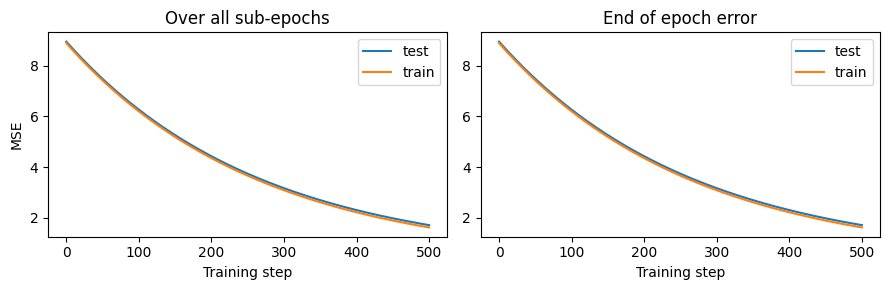

In [24]:

result_GD = GD(X_train, y_train, X_test, y_test, grad_method=loss_grad, n_epochs=epochs*10, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_GD["test_loss_list"], result_GD["train_loss_list"], 1)

### Stochastic

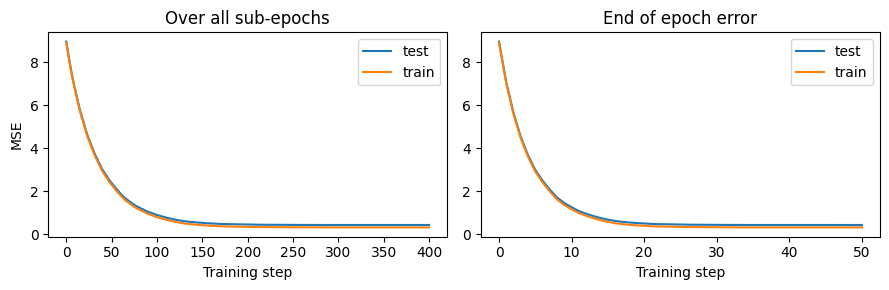

In [25]:
result_SGD = SGD(X_train, y_train, X_test, y_test, grad_method=loss_grad,n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_SGD["test_loss_list"], result_SGD["train_loss_list"], m)

### Adagrad

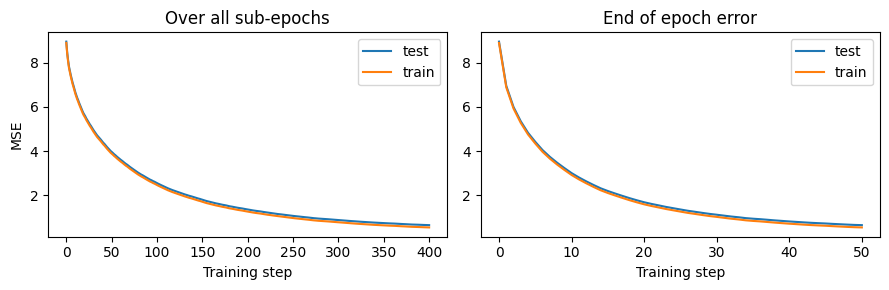

In [26]:
result_adagrad = SGD_adagrad(X_train, y_train, X_test, y_test, grad_method=loss_grad, n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_adagrad["test_loss_list"], result_adagrad["train_loss_list"], m)

### RMS prop

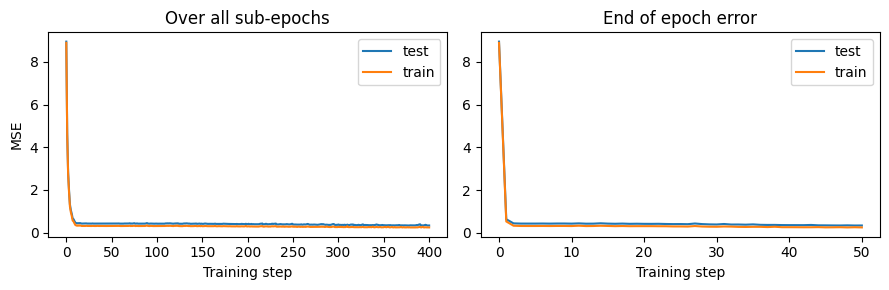

In [27]:
result_RMS_prop = SGD_RMS_prop(X_train, y_train, X_test, y_test, grad_method=loss_grad,n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_RMS_prop["test_loss_list"], result_RMS_prop["train_loss_list"], m)

### Adam

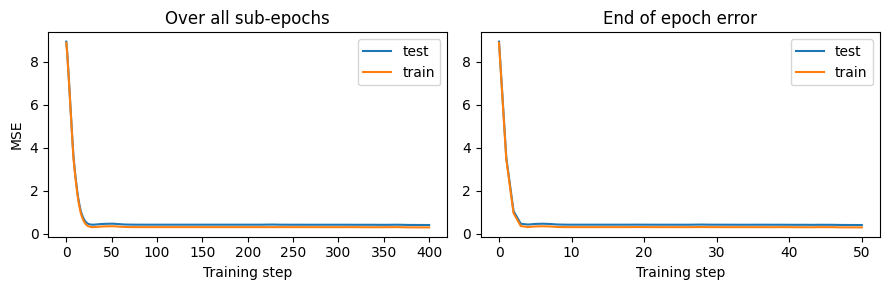

In [28]:
result_adam = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_adam["test_loss_list"], result_adam["train_loss_list"], m)